In [0]:
!wget -q https://s3.eu-central-1.wasabisys.com/aicrowd-practice-challenges/public/foodc/v0.1/train_images.zip
!wget -q https://s3.eu-central-1.wasabisys.com/aicrowd-practice-challenges/public/foodc/v0.1/test_images.zip
!wget -q https://s3.eu-central-1.wasabisys.com/aicrowd-practice-challenges/public/foodc/v0.1/train.csv
!wget -q https://s3.eu-central-1.wasabisys.com/aicrowd-practice-challenges/public/foodc/v0.1/test.csv

In [0]:
!mkdir data
!mkdir data/test
!mkdir data/train
!unzip train_images -d data/train
!unzip test_images -d data/test

In [0]:
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import lr_scheduler
from torch.utils.data import TensorDataset, DataLoader, Dataset
import torchvision
from torchvision import models
import torch.optim as optim
import pandas as pd
import numpy as np
import cv2
import os
from sklearn import preprocessing
import matplotlib.pyplot as plt
%matplotlib inline
import time
from PIL import Image

image_size_ = 256

In [0]:
class FoodData(Dataset):
    def __init__(self,data_list,data_dir = './',transform=None,train=True):
        super().__init__()
        self.data_list = data_list
        self.data_dir = data_dir
        self.transform = transform
        self.train = train
    
    def __len__(self):
        return self.data_list.shape[0]
    
    def __getitem__(self,item):
        if self.train:
          img_name,label = self.data_list.iloc[item]
        else:
          img_name = self.data_list.iloc[item]['ImageId']
        img_path = os.path.join(self.data_dir,img_name)
        img = cv2.imread(img_path,1)
        img = cv2.resize(img,(image_size_,image_size_))
        if self.transform is not None:
            img = self.transform(img)
        if self.train:
          return {
              'gt' : img,
              'label' : torch.tensor(label)

          }
        else:
          return {
              'gt':img
          }
        

In [0]:
train = pd.read_csv('train.csv')
le = preprocessing.LabelEncoder()
targets = le.fit_transform(train['ClassName'])
ntrain = train
ntrain['ClassName'] = targets 

In [0]:
transforms_train = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomRotation(90),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(),
    transforms.ToTensor(),
    transforms.Normalize( mean = np.array([0.485, 0.456, 0.406]),
    std = np.array([0.229, 0.224, 0.225]))
])
train_path = 'data/train/train_images'
train_data = FoodData(data_list= ntrain,data_dir = train_path,transform = transforms_train)

In [0]:
train = pd.read_csv('train.csv')
num = train['ClassName'].value_counts()
classes = train['ClassName'].unique()
print("Percentage of each class")
for cl in classes:
  print(cl,'\t',num[cl]/train.shape[0]*100,"%")

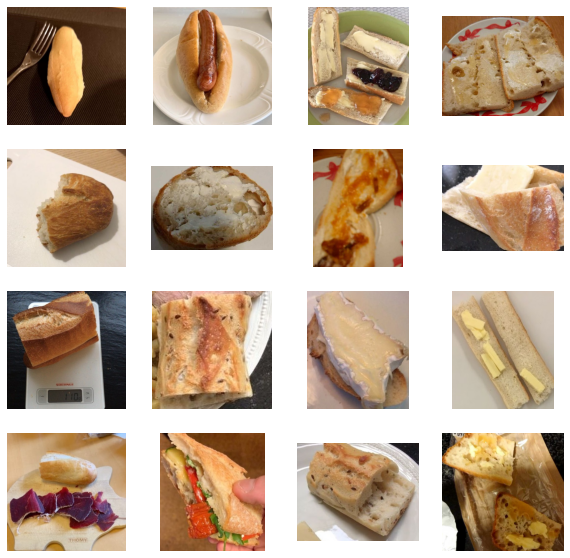

In [0]:
imgs = train.loc[train['ClassName'] == 'bread-french-white-flour']
plt.figure(figsize=(10,10))
for i in range(imgs[:16].shape[0]):
  path = imgs.iloc[i]['ImageId']
  image = cv2.imread(os.path.join(train_path,path),1)
  image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
  plt.subplot(4,4,i+1)
  plt.axis('off')
  plt.imshow(image)

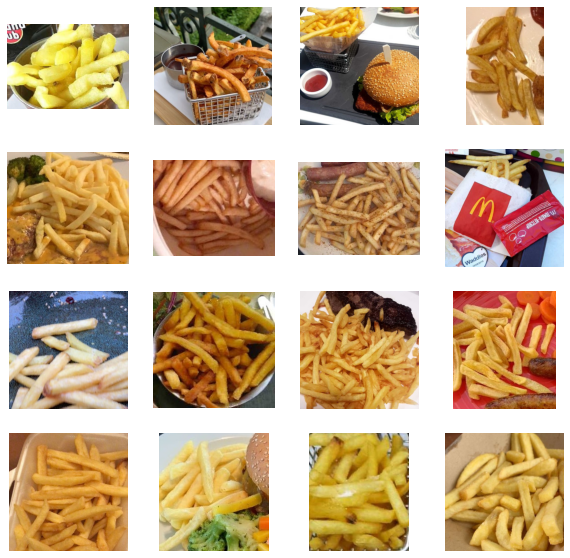

In [0]:
imgs = train.loc[train['ClassName'] == 'chips-french-fries']
plt.figure(figsize=(10,10))
for i in range(imgs[:16].shape[0]):
  path = imgs.iloc[i]['ImageId']
  image = cv2.imread(os.path.join(train_path,path),1)
  image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
  plt.subplot(4,4,i+1)
  plt.axis('off')
  plt.imshow(image)

In [0]:
batch = 64
valid_size = 0.2
num = train_data.__len__()
# Dividing the indices for train and cross validation
indices = list(range(num))
np.random.shuffle(indices)
split = int(np.floor(valid_size*num))
train_idx,valid_idx = indices[split:], indices[:split]

#Create Samplers
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

train_loader = DataLoader(train_data, batch_size = batch, sampler = train_sampler)
valid_loader = DataLoader(train_data, batch_size = batch, sampler = valid_sampler)


In [0]:
transforms_test = transforms.Compose([
                              
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize( mean = np.array([0.485, 0.456, 0.406]),
    std = np.array([0.229, 0.224, 0.225]))
])
test_path = 'data/test/test_images'
test = pd.read_csv('test.csv')
test_data = FoodData(data_list= test,data_dir = test_path,transform = transforms_test,train=False)

test_loader = DataLoader(test_data, batch_size=batch, shuffle=False)


In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device) 

cuda:0


In [0]:
dataloaders = {}
dataset_sizes = {}
dataloaders['train'] = train_loader
dataloaders['val'] = valid_loader
dataset_sizes['train'] = train_sampler.__len__()
dataset_sizes['val'] = valid_sampler.__len__()

In [0]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=5):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for data in dataloaders[phase]:
                inputs = data['gt'].squeeze(0).to(device)
                labels = data['label'].to(device)
                # inputs = inputs.to(device)
                # labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [0]:
import copy
model_ft = models.resnet50(pretrained=True)
# To only train the last layer
# for param in model_ft.parameters():
#     param.requires_grad = False
num_ftrs = model_ft.fc.in_features

# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Sequential(
                      nn.Linear(num_ftrs, 256), 
                      nn.ReLU(), 
                      nn.Dropout(0.4, inplace=True),
                      nn.Linear(256, 61),                   
                      nn.LogSoftmax(dim=1))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.000000001)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1) 

In [0]:
model_ft.load_state_dict(torch.load("/content/drive/My Drive/foodweights_foodc_day2.pth")) 

<All keys matched successfully>

In [0]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,num_epochs=5) 

Epoch 0/4
----------
train Loss: 0.6492 Acc: 0.8069
val Loss: 0.5111 Acc: 0.8482

Epoch 1/4
----------
train Loss: 0.6514 Acc: 0.8073
val Loss: 0.5132 Acc: 0.8444

Epoch 2/4
----------
train Loss: 0.6443 Acc: 0.8084
val Loss: 0.5107 Acc: 0.8503

Epoch 3/4
----------
train Loss: 0.6533 Acc: 0.8072
val Loss: 0.5029 Acc: 0.8455

Epoch 4/4
----------
train Loss: 0.6455 Acc: 0.8123
val Loss: 0.5141 Acc: 0.8460

Training complete in 11m 5s
Best val Acc: 0.850322


In [0]:
torch.save(model_ft.state_dict(), "/content/drive/My Drive/foodweights_foodc_day2.pth")  

In [0]:
model_ft.eval()
correct = 0
total = 0
pred_list = []
correct_list = []
with torch.no_grad():
    for images in valid_loader:
        data = images['gt'].squeeze(0).to(device)
        target = images['label'].to(device)
        outputs = model_ft(data)
        _, predicted = torch.max(outputs.data, 1)
        total += target.size(0)
        pr = predicted.detach().cpu().numpy()
        for i in pr:
          pred_list.append(i)
        tg = target.detach().cpu().numpy()
        for i in tg:
          correct_list.append(i)
        correct += (predicted == target).sum().item()

print('Accuracy of the network on the 10000 test images: %f %%' % (
    100 * correct / total)) 

Accuracy of the network on the 10000 test images: 84.656652 %


In [0]:
from sklearn.metrics import f1_score,precision_score,log_loss   
print("F1 score :",f1_score(correct_list,pred_list,average='micro')*100) 

F1 score : 84.65665236051501


In [0]:
model_ft.eval()

preds = []
with torch.no_grad():
    for images in test_loader:
        data = images['gt'].squeeze(0).to(device)
        outputs = model_ft(data)
        _, predicted = torch.max(outputs.data, 1)
        pr = predicted.detach().cpu().numpy()
        for i in pr:
          preds.append(i) 

In [0]:
df = pd.DataFrame(le.inverse_transform(preds),columns=['ClassName'])
df.to_csv('FOODC_submissionsuju.csv',index=False) 

In [0]:
from google.colab import files
files.download('FOODC_submissionsuju.csv') 